In [2]:
from os import listdir
import pandas as pd
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk import pos_tag
import re
import string
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from nltk.cluster.util import cosine_distance
import networkx as nx
import statistics

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds

**Here is the documents**

* I have a documents which is supposed to be summarized.
* I have used LSA - Latent Semantic Analysis method to summarize the documts.
* To do so I have the following algorithms

**Algorithms**
* Applying SVD to them using some sort of feature weights i.e TF-IDF weights
* Get the sentence vectors from the matrix V (k rows).
* Get the top k singular values from S
* Apply a threshold-based approach to remove singular values that are less than half of the largest singular value if any exist. This is a heuristic, and you can play around with this value if you want.Mathematically, S i i i = < 0 ff S S( ) 1/2 (max S).
* Multiply each term sentence column from V squared with its corresponding singular value from S also squared, to get sentence weights per topic.
* Compute the sum of the sentence weights across the topics and take the square root of the final score to get the salience scores for each sentence in the document

In [3]:
FINAL_CORPUS = './data/corpus/corpus_cleaned.pkl'
corpus = pd.read_pickle(FINAL_CORPUS)
# corpus.sample(3)
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90887 entries, 0 to 91589
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   article                 90887 non-null  object
 1   summary                 90887 non-null  object
 2   article_char_count      90887 non-null  int64 
 3   article_word_count      90887 non-null  int64 
 4   article_sentence_count  90887 non-null  int64 
 5   summary_char_count      90887 non-null  int64 
 6   summary_word_count      90887 non-null  int64 
 7   summary_sentence_count  90887 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.2+ MB


In [4]:
stop_words = nltk.corpus.stopwords.words('english')

In [5]:
text = """
    The Elder Scrolls V: Skyrim is an action role-playing video game developed by Bethesda Game Studios 
    and published by Bethesda Softworks. It is the fifth main installment in The Elder Scrolls series, 
    following The Elder Scrolls IV: Oblivion.
    The game's main story revolves around the player character's quest to defeat Alduin the World-Eater, 
    a dragon who is prophesied to destroy the world. The game is set 200 years after the events of Oblivion 
    and takes place in the fictional province of Skyrim. Over the course of the game, the player completes 
    quests and develops the character by improving skills. The game continues the open-world tradition of 
    its predecessors by allowing the player to travel anywhere in the game world at any time, and to ignore 
    or postpone the main storyline indefinitely.
    The team opted for a unique and more diverse open world than Oblivion's Imperial Province of Cyrodiil, 
    which game director and executive producer Todd Howard considered less interesting by comparison. 
    The game was released to critical acclaim, with reviewers particularly mentioning the character advancement 
    and setting, and is considered to be one of the greatest video games of all time.
    The Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or 
    third-person perspective. The player may freely roam over the land of Skyrim which is an open world 
    environment consisting of wilderness expanses, dungeons, cities, towns, fortresses, and villages. 
    Players may navigate the game world more quickly by riding horses or by utilizing a fast-travel system 
    which allows them to warp to previously discovered locations. The game's main quest can be completed or 
    ignored at the player's preference after the first stage of the quest is finished. However, some quests 
    rely on the main storyline being at least partially completed. Non-player characters (NPCs) populate the 
    world and can be interacted with in a number of ways: the player may engage them in conversation, 
    marry an eligible NPC, kill them or engage in a nonlethal "brawl". The player may 
    choose to join factions which are organized groups of NPCs — for example, the Dark Brotherhood, a band 
    of assassins. Each of the factions has an associated quest path to progress through. Each city and town 
    in the game world has jobs that the player can engage in, such as farming.
    Players have the option to develop their character. At the beginning of the game, players create 
    their character by selecting their sex and choosing between one of several races including humans, 
    orcs, elves, and anthropomorphic cat or lizard-like creatures and then customizing their character's 
    appearance. Over the course of the game, players improve their character's skills which are numerical 
    representations of their ability in certain areas. There are eighteen skills divided evenly among the 
    three schools of combat, magic, and stealth. When players have trained skills enough to meet the 
    required experience, their character levels up. Health is depleted primarily when the player 
    takes damage and the loss of all health results in death. Magicka is depleted by the use of spells, 
    certain poisons and by being struck by lightning-based attacks. Stamina determines the player's 
    effectiveness in combat and is depleted by sprinting, performing heavy "power attacks" 
    and being struck by frost-based attacks. Skyrim is the first entry in The Elder Scrolls to 
    include dragons in the game's wilderness. Like other creatures, dragons are generated randomly in 
    the world and will engage in combat with NPCs, creatures and the player. Some dragons may attack 
    cities and towns when in their proximity. The player character can absorb the souls of dragons 
    in order to use powerful spells called "dragon shouts" or "Thu'um". A regeneration 
    period limits the player's use of shouts in gameplay.
    Skyrim is set around 200 years after the events of The Elder Scrolls IV: Oblivion, although it is 
    not a direct sequel. The game takes place in Skyrim, a province of the Empire on the continent of 
    Tamriel, amid a civil war between two factions: the Stormcloaks, led by Ulfric Stormcloak, and the 
    Imperial Legion, led by General Tullius. The player character is a Dragonborn, a mortal born with 
    the soul and power of a dragon. Alduin, a large black dragon who returns to the land after being 
    lost in time, serves as the game's primary antagonist. Alduin is the first dragon created by Akatosh, 
    one of the series' gods, and is prophesied to destroy and consume the world."""

In [6]:

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    porter = PorterStemmer()
    filtered_tokens = [porter.stem(word) for word in filtered_tokens]
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [6]:
def low_rank_svd(matrix, singular_count=10):
    u, s, vt = svds(matrix, k=singular_count)
    return u, s, vt

In [7]:
def lsa(text,threshold=0.5):
    text = re.sub(r'\n|\r', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = text.strip()
    sentences = nltk.sent_tokenize(text)

    norm_sentences = normalize_corpus(sentences)
    
    tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
    dt_matrix = tv.fit_transform(norm_sentences)
    dt_matrix = dt_matrix.toarray()

    vocab = tv.get_feature_names_out()
    td_matrix = dt_matrix.T
    num_sentences = int(len(nltk.sent_tokenize(text)) * threshold)
    num_topics = 1

    u, s, vt = low_rank_svd(td_matrix, singular_count=num_topics)  
    term_topic_mat, singular_values, topic_document_mat = u, s, vt

    sv_threshold = threshold
    salience_scores = np.sqrt(np.dot(np.square(singular_values), np.square(topic_document_mat)))
    min_sigma_value = sv_threshold * mean(salience_scores)
    salience_scores[salience_scores<=min_sigma_value]=0
    top_sentence_indices = (-salience_scores).argsort()[salience_scores!=0]
    top_sentence_indices.sort()
    summary='\n'.join(np.array(sentences)[top_sentence_indices])

    return summary

In [16]:
lsa(text)

[ 0  1  2  3  4  5  8  9 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26 29
 30 31 33 34]


'The Elder Scrolls V: Skyrim is an action role-playing video game developed by Bethesda Game Studios and published by Bethesda Softworks.\nIt is the fifth main installment in The Elder Scrolls series, following The Elder Scrolls IV: Oblivion.\nThe game\'s main story revolves around the player character\'s quest to defeat Alduin the World-Eater, a dragon who is prophesied to destroy the world.\nThe game is set 200 years after the events of Oblivion and takes place in the fictional province of Skyrim.\nOver the course of the game, the player completes quests and develops the character by improving skills.\nThe game continues the open-world tradition of its predecessors by allowing the player to travel anywhere in the game world at any time, and to ignore or postpone the main storyline indefinitely.\nThe Elder Scrolls V: Skyrim is an action role-playing game, playable from either a first or third-person perspective.\nThe player may freely roam over the land of Skyrim which is an open worl

In [23]:
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)]

      return rouge_score

# 12168,34861,87066,13950,40082,84878,87026
idxs=[12168,34861,87066,13950,40082,84878,87026]
for idx in idxs:
    article = corpus.loc[idx, 'article']
    reference_summary = corpus.loc[idx, 'summary']
    hypothesis_summary = lsa(article,0.9)
    # nice_print(article, reference_summary, hypothesis_summary)
    print(rouge_scoring(hypothesis_summary,reference_summary))

{'f': 0.1764705882352941, 'p': 0.09722222222222222, 'r': 0.9545454545454546}
{'f': 0.34615384615384615, 'p': 0.226890756302521, 'r': 0.7297297297297297}
{'f': 0.36363636363636365, 'p': 0.2537313432835821, 'r': 0.6415094339622641}
{'f': 0.3589743589743589, 'p': 0.2692307692307692, 'r': 0.5384615384615384}
{'f': 0.15300546448087432, 'p': 0.08450704225352113, 'r': 0.8076923076923077}
{'f': 0.1288135593220339, 'p': 0.07050092764378478, 'r': 0.7450980392156863}
{'f': 0.09523809523809525, 'p': 0.05194805194805195, 'r': 0.5714285714285714}


In [13]:
def nice_print(article, reference_summary, hypothesis_summary, width  = 300):
  dedented_text = lambda text: textwrap.dedent(text).strip()
  if article:
    print('ARTICLE')
    print(textwrap.fill(dedented_text(article), width=width), '\n')
  if reference_summary:
    print('REFERENCE SUMMARY: Summary from Dataset')
    print(textwrap.fill(dedented_text(reference_summary), width=width), '\n')
  if hypothesis_summary:
    print('HYPOTHESIS SUMMARY : Summary generated from Algorithm')
    print(textwrap.fill(dedented_text(hypothesis_summary), width=width), '\n')

In [14]:
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)]

      return rouge_score

In [15]:
# idx = corpus.sample(1).index[0]
idx=69114
print(idx)
article = corpus.loc[idx, 'article']
reference_summary = corpus.loc[idx, 'summary']
hypothesis_summary = lsa(article)
nice_print(article, reference_summary, hypothesis_summary)




evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = 1,
                           limit_length = True,
                           length_limit = 100,
                           length_limit_type = 'words',
                           alpha = 0.5, # Default F1_score
                           stemming=True)

hypothesis = hypothesis_summary
reference = reference_summary

scores = evaluator.get_scores(hypothesis, reference)
print(scores) 

69114
ARTICLE
A blond girl found in Greece whose birth parents were traced to a Bulgarian Roma village will be cared for by a foster family when she's returned to Bulgaria, the government's social services agency said  Maria, as the girl was known by the Roma couple with whom she was living in central Greece, was
at the center of an international mystery after police discovered her.  DNA tests eventually showed that Saska Ruseva and her husband, Atanas Rusev, were her biological parents.  Her mother told CNN that she wants her child back -- but that seems unlikely to happen for now.  Maria, now being cared
for by Greek children's charity Smile of a Child, will instead be cared for by a foster family.  The parents and their nine children have been living in poverty in a tumbledown, one-room mud brick house in the village of Nikolaevo, in central Bulgaria.  Emil Todorov, director of the Children
Protection Department of Bulgaria's Agency for Social Assistance, told CNN it was not yet cle

In [16]:
idxs=[69114,65351]
for idx in idxs:
    article = corpus.loc[idx, 'article']
    reference_summary = corpus.loc[idx, 'summary']
    hypothesis_summary = lsa(article)
    nice_print(article, reference_summary, hypothesis_summary)
    print(rouge_scoring(hypothesis_summary,reference_summary))

ARTICLE
A blond girl found in Greece whose birth parents were traced to a Bulgarian Roma village will be cared for by a foster family when she's returned to Bulgaria, the government's social services agency said  Maria, as the girl was known by the Roma couple with whom she was living in central Greece, was
at the center of an international mystery after police discovered her.  DNA tests eventually showed that Saska Ruseva and her husband, Atanas Rusev, were her biological parents.  Her mother told CNN that she wants her child back -- but that seems unlikely to happen for now.  Maria, now being cared
for by Greek children's charity Smile of a Child, will instead be cared for by a foster family.  The parents and their nine children have been living in poverty in a tumbledown, one-room mud brick house in the village of Nikolaevo, in central Bulgaria.  Emil Todorov, director of the Children
Protection Department of Bulgaria's Agency for Social Assistance, told CNN it was not yet clear wha

In [32]:
def run_on_corpus(df,thresholds,n_predictions):

  t0 = time.time()
  sampling_interval = len(df) // n_predictions
  index = df.index[::sampling_interval][:n_predictions]
  data = df.loc[index, 'summary']
  predictions = pd.DataFrame( data = data.values , columns = ['reference'], index = index)
  
  for threshold in thresholds:
    predicted_column = str("LSA") + "_" + str("@")+str(threshold)
    print('Prediction colum: {}'.format(predicted_column))
    predictions.loc[index, predicted_column] = df.loc[index, 'article'].apply(lsa,threshold=float(threshold))
    print('Time taken {:.2f} minutes'.format((time.time() - t0)/60))
              
    
  print()
  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return predictions

In [33]:
n_predictions = 10000
thresholds=[0.2,0.4,0.6,0.8,1]
predictions_test = run_on_corpus(corpus,thresholds,n_predictions)



Prediction colum: LSA_@0.2
Time taken 2.23 minutes
Prediction colum: LSA_@0.4
Time taken 4.47 minutes
Prediction colum: LSA_@0.6
Time taken 6.70 minutes
Prediction colum: LSA_@0.8
Time taken 8.93 minutes
Prediction colum: LSA_@1
Time taken 11.25 minutes

Total time to execute: 11.25 minutes


In [34]:
predictions_test.sample(5)

,reference,LSA_@0.2,LSA_@0.4,LSA_@0.6,LSA_@0.8,LSA_@1
46356,The Pentagon will report on Army suicide rates...,The U.S. Army hopes it can do a better job of ...,The U.S. Army hopes it can do a better job of ...,The U.S. Army hopes it can do a better job of ...,The U.S. Army hopes it can do a better job of ...,The U.S. Army hopes it can do a better job of ...
90460,"Clinton, Mullen say U.S., Pakistan must conti...","Adm. Mike Mullen, chairman of the Joint Chiefs...","Adm. Mike Mullen, chairman of the Joint Chiefs...","Adm. Mike Mullen, chairman of the Joint Chiefs...","Adm. Mike Mullen, chairman of the Joint Chiefs...","Adm. Mike Mullen, chairman of the Joint Chiefs..."
63302,NYPD commissioner: Chiefs need to embrace need...,Confidence.\nPassion.\nSmith is the police chi...,Confidence.\nPassion.\nSmith is the police chi...,Confidence.\nPassion.\nSmith is the police chi...,Confidence.\nPassion.\nSmith is the police chi...,Confidence.\nPassion.\nSmith is the police chi...
38572,Recent moments in pop culture show women takin...,They all said no.\nShe was disappointed.\nBody...,They all said no.\nShe was disappointed.\nBody...,They all said no.\nShe was disappointed.\nBody...,They all said no.\nShe was disappointed.\nBody...,They all said no.\nShe was disappointed.\nBody...
5624,Al Qaeda's involvement with a kidnapping woul...,"In the eighth episode of a series called ""A Me...","In the eighth episode of a series called ""A Me...","In the eighth episode of a series called ""A Me...","In the eighth episode of a series called ""A Me...","In the eighth episode of a series called ""A Me..."


In [35]:
len(predictions_test)

10000

In [36]:
def calculate_rouge(df, max_n = 1, alpha = 0.5, score = 'F1'):
  t0 = time.time()
  evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
  if score == 'F1':
    score_entry = 'f'
  elif score == 'Precision':
    score_entry = 'p'
  else:
    score == 'Recall'
    score_entry = 'r'
    
  scores_df = pd.DataFrame()
  for column in df.columns[1:]:
    score_column = column + '_' + score
    for idx in df.index:
      hypothesis = df.loc[idx, column]
      reference = df.loc[idx, 'reference']
      rouge_scores = evaluator.get_scores(hypothesis, reference)
      scores_df.loc[idx, score_column] = rouge_scores['rouge-' + str(max_n)][score_entry]

  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return scores_df

In [37]:
max_n = 1
alpha = 0.5 # Default F1_score
score = 'F1'
predictions_scores = calculate_rouge(predictions_test, max_n, alpha, score)

Total time to execute: 7.22 minutes


In [39]:
predictions_scores.mean()

LSA_@0.2_F1    0.185696
LSA_@0.4_F1    0.185692
LSA_@0.6_F1    0.185703
LSA_@0.8_F1    0.185709
LSA_@1_F1      0.185694
dtype: float64

C:\Users\kk910\AppData\Local\Temp\ipykernel_3132\1412836247.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)


Text(0.5, 1.0, 'F1 score of ')

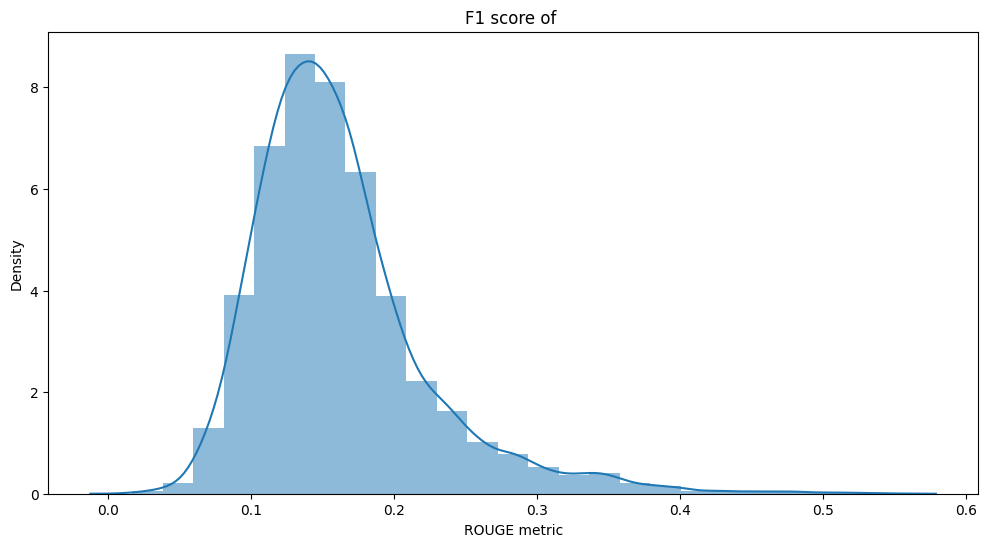

In [105]:
score_column = 'LSA_F1_F1'
# print('F1 average = {:.4f}'.format(predictions_scores[score_column].max()))
# print('F1 standard deviation = {:.4f}'.format(predictions_scores[score_column].std()))


_, ax = plt.subplots(figsize = (12,6))
sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)
ax.set_xlabel('ROUGE metric')
ax.set_title('F1 score of ')

In [106]:
def  sentence_tokenize(text):
     sentence_tokenized = list()
     for txt in text.split('.'):
          sentence_tokenized += sent_tokenize(txt)
     return sentence_tokenized

def len_sent_tokenize(text):
  return len(sentence_tokenize(text))



qty_of_sentences = predictions_test['LSA_F1'].apply(len_sent_tokenize)

In [85]:
qty_of_sentences_reference = predictions_test['reference'].apply(len_sent_tokenize)

diff_number_of_sentences = qty_of_sentences - qty_of_sentences_reference

In [86]:
print(diff_number_of_sentences)
print("Max Difference",np.max(diff_number_of_sentences))
print("Minimum Difference",np.min(diff_number_of_sentences))

0        16
9        15
18       16
27       16
36       16
         ..
90649    14
90658    16
90667    16
90676    17
90685    16
Length: 10000, dtype: int64
Max Difference 19
Minimum Difference -2


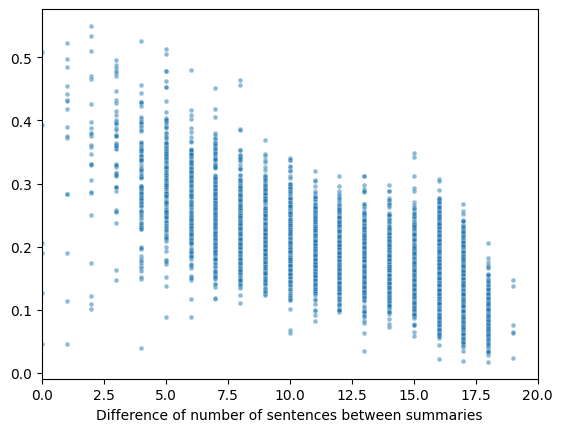

In [89]:
sns.scatterplot(x = diff_number_of_sentences, 
            y = predictions_scores['LSA_F1_F1'].values,
            alpha =0.5, s = 12)

plt.xlabel('Difference of number of sentences between summaries')
plt.xlim((0,+20))
plt.show()

In [115]:
len(nltk.sent_tokenize(text))

35